## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

2024-04-23 10:43:26.083907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

# Analiza obrazów - Zbiór EMNIST

Jako zbiorów treningowych do analizy obrazów użyjemy rozszerzonego zbioru MNIST -
[EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset)
zawierającego dużą liczbę zdjęć ręcznie pisanych liter i cyfr. Zdjęcia mają rozdzielczość `28x28` pikseli,
a każdy piksel koduje poziom szarości w 8 bitowej skali.

# Przygotowanie danych

**Proszę:**

* pobrać zbiór [EMNIST](https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip)
* rozpakować plik .zip
* załadować do środowiska Colab, do katalogu `data` pliki (`label` i `images`) dla zbioru `emnist-digits-test`
* rozpakować w środowisku Colab pliki `.gzip`

**Uwaga:**

* pliki są duże. Optymalnie jest je pobrać bezpośrednio na Colab, lub na dysk Google

In [2]:
!wget https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip
!uzip gzip.zip
!gzip -d gzip/*test*

--2024-04-23 10:43:27--  https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip
Resolving biometrics.nist.gov (biometrics.nist.gov)... 54.85.30.225
Connecting to biometrics.nist.gov (biometrics.nist.gov)|54.85.30.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip.1’

gzip.zip.1          100%[===================>] 535.73M   440KB/s    in 4m 53s  

2024-04-23 10:48:23 (1.83 MB/s) - ‘gzip.zip.1’ saved [561753746/561753746]

/usr/bin/sh: 1: uzip: not found
gzip: gzip/*test*.gz: No such file or directory


Dane wczytamy korzystając z gotowej funkcji `getEMNIST(datasetName, datasetPath)` która zwraca krotkę `(features, labels)` dla zbioru o nazwie odpowiadającej nazwie odpowiedniego pliku, np.:
  ```Python
  
  x, y = getEMNIST('emnist-digits-test', datasePath)
  
  ```
  <br></br>

**Proszę:**

* umieścić funkcję w module `modules/emnist_functions.py`  
* rozpakować dane treningowe dla liczb: `emnist-digits-test`
* wydzielić `30 000` przykładów na zbiór uczący
* wydzielić `10 000` przykładów na zbiór walidacyjny

**Uwagi:**

* dane są zapisane w binarnym formacie IDX. Do ich dekodowania można użyć pakietu `idx2numpy`. Pakiet można doinstalować
  do aktualnej sesji korzystając z komendy `pip`. W komórce notatnika komendy linii poleceń trzeba poprzedzić wykrzyknikiem:
  ```Shell
  
  !pip install idx2numpy
  ```
  <br></br>
* zamiast wydzielania explicite zbioru walidacyjnego można użyć parametru `validation_split` metody `keras.model.fit()`:
  ```Python
  
  history = model.fit(x=x_train, y=y_train,
                    epochs=nEpochs,
                    batch_size = batchSize,
                    validation_split=0.1,   # 10% zbioru treningowego wydzielone na zbiór walidacyjny
                    callbacks=callbacks,
                    verbose=0)
  ```

In [3]:
!pip install idx2numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
def getEMNIST(datasetName, datasetPath):

    import idx2numpy
    fileName = datasetPath+"/"+datasetName+'-images-idx3-ubyte'
    features = idx2numpy.convert_from_file(fileName)

    fileName = datasetPath+"/"+datasetName+'-labels-idx1-ubyte'
    labels = idx2numpy.convert_from_file(fileName)
    return (features, labels)

#BEGIN_SOLUTION
datasetName = "emnist-digits-test"
datasetPath = "../data/EMNIST/gzip/"
features, labels = getEMNIST(datasetName, datasetPath)

nTrainExamples = 30000
nValExamples = 10000
x_train = features[:nTrainExamples]
y_train = labels[:nTrainExamples]

x_val = features[-nValExamples:]
y_val = labels[-nValExamples:]

print(colored("Training data shapes: ","blue"), x_train.shape, y_train.shape)
print(colored("Validation data shapes: ","blue"), x_val.shape, y_val.shape)
#END_SOLUTION
pass

Training data shapes:  (30000, 28, 28) (30000,)
Validation data shapes:  (10000, 28, 28) (10000,)


**Proszę:**

* napisać funkcję `plotMNIST(x, y, y_pred)`, która rysuje cztery losowe obrazy ze zbioru cech `x`, podpisane dwoma rodzajami etykiet
  zawartych w macierzach `y` i `y_pred`
* po dopracowaniu kodu funkcji umieścić ją w module `modules/emnist_functions.py`

**Wskazówka:**
* do rysowania obrazów można użyć funkcji `imshow(imgeData)`

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


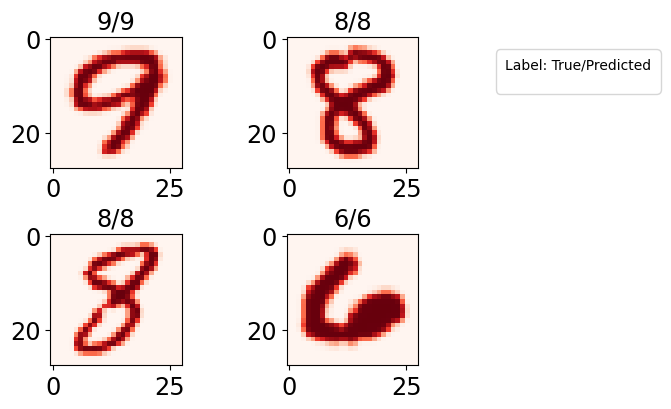

In [5]:
#BEGIN_SOLUTION
def plotMNIST(x, y, y_pred):
    indices = np.random.default_rng().integers(0, len(x), (4))
    fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5))

    for index, axis in zip(indices, axes.flatten()):
        title = "{}/{}".format(y[index],y_pred[index])
        axis.imshow(x[index].T, cmap=plt.get_cmap('Reds'), label="A")
        axis.set_title(title)

    axes[0,1].legend(bbox_to_anchor=(1.5,1), loc='upper left', title="Label: True/Predicted")
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.4, hspace=0.5)

plotMNIST(x_train, y_train, y_train)
#END_SOLUTION
pass

**Proszę:**

* wywołać funkcje ładującą dane i rysującą rysunki korzystając z modułu `emnist_functions`

2024-04-23 10:48:26.812559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 10:48:26.812690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 10:48:26.816619: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

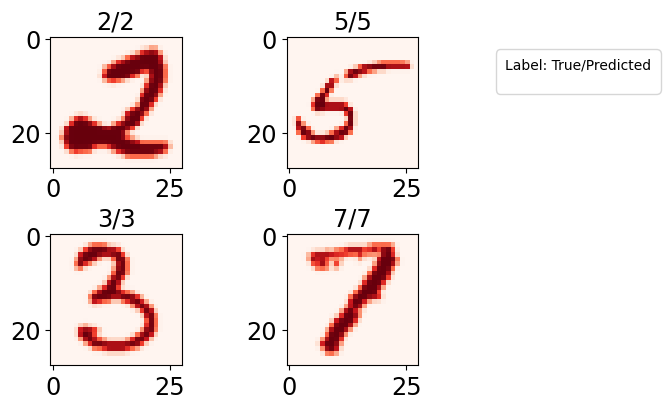

In [6]:
import emnist_functions as emnist_fcn

datasetName = "emnist-digits-test"
datasetPath = "../data/EMNIST/gzip/"
x, y = emnist_fcn.getEMNIST(datasetName, datasetPath)
emnist_fcn.plotMNIST(x, y, y)

**Proszę:**

  * narysować histogramy krotności poszczególnych klas dla zbiorów treningowego i walidacyjnego

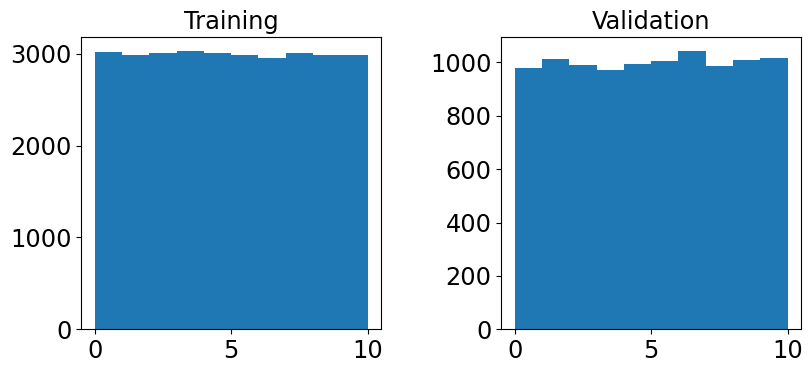

In [7]:
#BEGIN_SOLUTION
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].hist(y_train, bins=np.linspace(0,10,11));
axes[0].set_title("Training")

axes[1].hist(y_val,bins=np.linspace(0,10,11));
axes[1].set_title("Validation")
plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.4, hspace=0.5)
#END_SOLUTION
pass

## Rozpoznawanie ręcznie pisanych cyfr

Mamy przed sobą zagadnienie kategoryzacji z wieloma klasami. Etykiety klas są podane w postaci numeru klasy:
```Python
print(y_train[:3])
[8 9 6]
```

Sieć, którą skonstruujemy, będzie estymowała prawdopodobieństwo przynależności do klasy na podstawie cech:

$$
{\huge
f_{g}(x) =  P(g|x)
}
$$

następnie użyjemy klasyfikacji Bayesa przypisując klasę o maksymalnym prawdopodobieństwie:

$$
{\huge
g = argmax_{g \in G} f_{g}(x)
}
$$

Jako funkcji straty użyjemy entropii krzyżowej dla wielu kategorii. Mamy do wyboru dwa warianty:

* `sparse_categorical_crossentropy` - implementacja zakładająca, że etykiety zawierają numery klas

* `categorical_crossentropy` - implementacja zakładająca, że etykiety zawierają wektory prawdopodobieństw przynależności do klas:

```Python
x = tf.one_hot(y_train[:3], 10)
print(x)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(3, 10), dtype=float32)
```  

W naszym przypadku każdy przykład należy do jednej klasy, więc wektor prawdopodobieństw zawiera zera, z wyjątkiem elementu odpowiadającego klasie, do której należy przykład. Taka reprezentacja nazywa się gorąco jedynkową, ang. `one_hot`


* warstwa wyjściowa ma teraz liczbę neuronów równą liczbie klas - każdy neuron zwraca prawdopodobieństwo przynależności do danej klasy
* funkcja aktywacji warstwy wyjściowej powinna być ustawiona na `softmax` by zapewnić normalizację prawdopodobieństwa przykładu do 1:

$$
{\huge
\sum _{g} f_{g}(x) =  1
}
$$

**Proszę:**

* skonstruować sieć w pełni połączoną rozpoznającą ręcznie napisaną cyfrę. Sieć powinna mieć ``128`` neuronów w każdej z
  ``16`` warstw.
* budowa sieci powinna być wykonana z użyciem funkcji `getModel(...)`
* przeprowadzić trening w 20 epokach i narysować zmianę funkcji straty w kolejnych epokach
* trening powienien uwzględniać harmonogram współczennika uczenia
* trening **nie** powinien używać wczesnego zatrzymania - chcemy pobadać efekty zbyt długiego treningu
* obliczyć dokładność, `accuracy` na zbiorach treningowym i walidacyjnym
* skomentować wykresy funkcji straty - **Czy widać na nich oznaki przetrenowania?**

**Uwaga:** proszę zwrócić uwagę na kształt danych wejściowych

I0000 00:00:1713869310.829579     194 service.cc:145] XLA service 0x78a348004150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713869310.829594     194 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1713869310.829596     194 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-04-23 10:48:30.883973: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 10:48:31.168215: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1713869312.146484     250 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1125', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1713869313.428636     194 asm_compiler.cc:369] ptxas 

Evaluation on training dataset:
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9871 - loss: 0.0542
Evaluation on validation dataset:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.9726 - loss: 0.1439
CPU times: user 52.7 s, sys: 1.61 s, total: 54.3 s
Wall time: 25.6 s


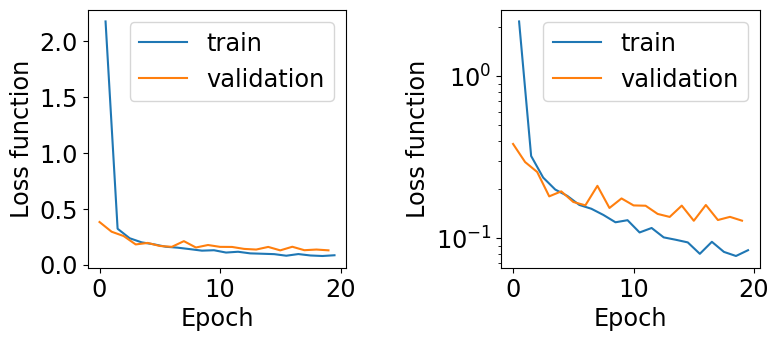

In [8]:
%%time
#BEGIN_SOLUTION
inputShape = (28,28)

nNeurons = np.full((16),128)
nOutputNeurons = 10

def getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="linear", nOutputNeurons=1):

    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = tf.keras.layers.Flatten()(inputs)

    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation,
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_initializer="HeNormal",
                                  #kernel_regularizer=tf.keras.regularizers.L2(l2=0.01),
                                  name="layer_"+str(iLayer))(x)

    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    return model

model = getModel(inputShape=inputShape, nOutputNeurons=nOutputNeurons,
                 nNeurons=nNeurons,
                 hiddenActivation="relu",
                 outputActivation="softmax")

#configure learning process
initial_learning_rate = 1E-3
batchSize = 64
nEpochs = 20

nStepsPerEpoch = len(x_train)/batchSize
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#run training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1E-3)
#callbacks = [early_stop_callback]
callbacks = []

history = model.fit(x=x_train, y=y_train,
                    epochs=nEpochs,
                    batch_size = batchSize,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=0)
plf.plotTrainHistory(history)
print(colored("Evaluation on training dataset:","blue"))
model.evaluate(x_train, y_train)
print(colored("Evaluation on validation dataset:","blue"))
model.evaluate(x_val, y_val)
#END_SOLUTION
pass

**Proszę:**

* użyć kryterium Bayesa do skonstruowania finalnej odpowiedzi modelu na pytanie **Do której klasy należy dany przykład?**
* narysować macierz pomyłek dla zbioru treningowego i walidacyjnego
* macierze pomyłek proszę znormalizować względem prawdziwych etykiet.

**Wskazówka:** do rysowania macierzy pomyłek można użyć klasy `sklearn.metrics.ConfusionMatrixDisplay`

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step


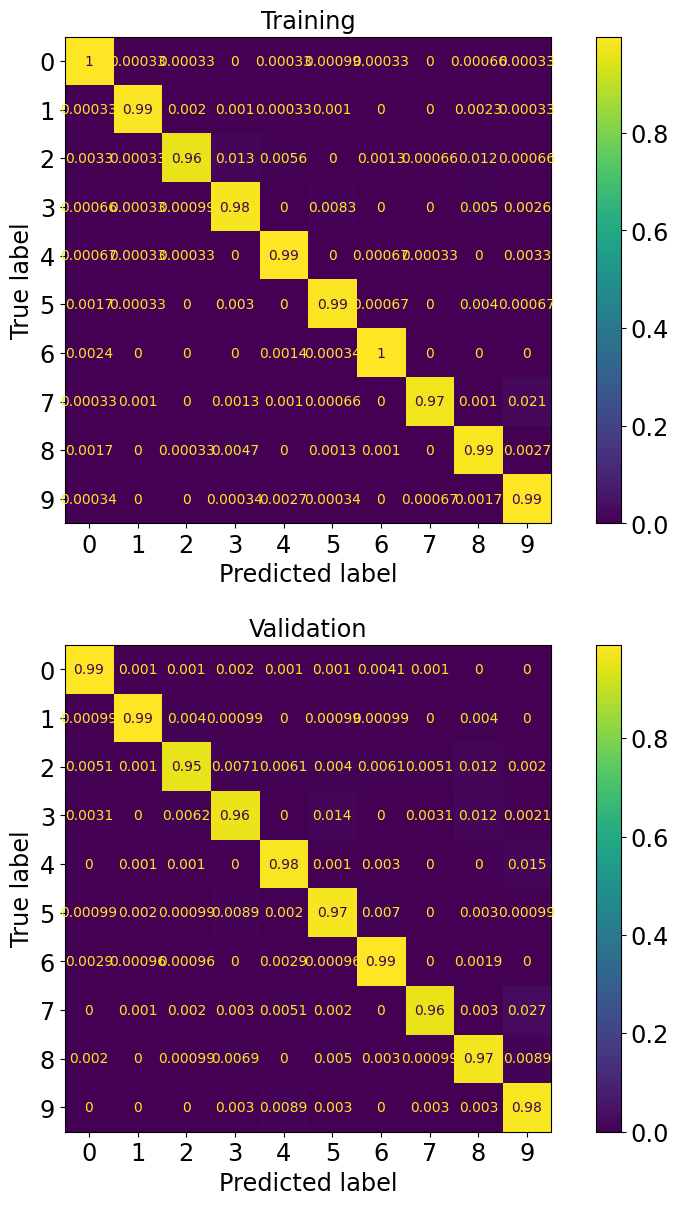

In [9]:
#BEGIN_SOLUTION
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 1, figsize=(10,15))
y_pred = tf.argmax(model.predict(x_train), axis=1)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=axes[0])

y_pred = tf.argmax(model.predict(x_val), axis=1)
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, normalize="true", ax=axes[1])

axes[0].set_title("Training")
axes[1].set_title("Validation")
plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.25)
#END_SOLUTION
pass

**Proszę:**

* narysować cztery losowe przykłady z informacją etykietach: prawdziwej i przyznanej przez model
* narysować cztery przykłady, w których odpowiedź modelu **nie** jest poprawna

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


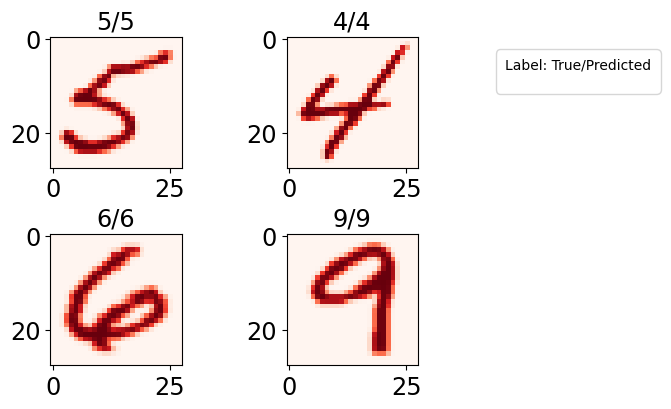

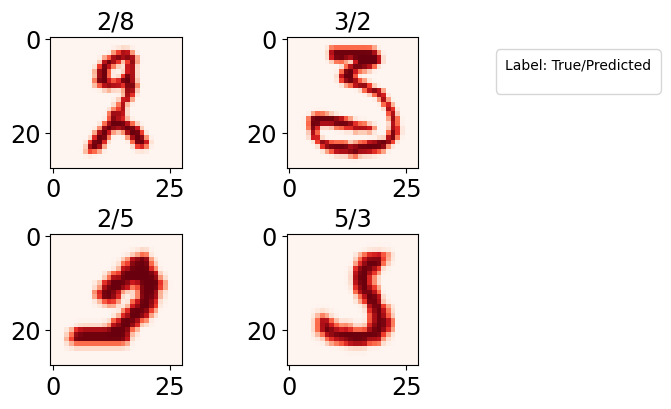

In [10]:
#BEGIN_SOLUTION
plotMNIST(x_val, y_val, y_pred)
mask = y_val!=y_pred
plotMNIST(x_val[mask], y_val[mask], y_pred[mask])
#END_SOLUTION
pass

## Zapis modelu

Model stworzony w Keras może być zapisany w całości - struktura i wagi lub jako same wagi.
W nazwie pliku modelu warto zakodować podstawowe meta dane o treningu, np. datę i liczbę epok.

In [11]:
currentTime = datetime.now().strftime("%b_%d_%Y_%H_%M")
path = "training/{epoch:04d}_"+currentTime+".keras"
model.save(path.format(epoch=nEpochs));

## Wczytywanie modelu

Model można wczytać w dowolnym innym miejscu kodu. Wczytany model pozwala na te same operacje co oryginalny model "z kodu",
w szczególności:

* kontynuację treningu
* wykonanie predykcji

In [12]:
nEpochsSaved = 20
checkpoint_path = "training/{epoch:04d}_"+currentTime+".keras"
model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved))
model.summary()
print(colored("Evaluation on validation dataset:","blue"))
model.evaluate(x_val, y_val)

Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_0 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,048,351 (4.00 MB)

 Trainable params: 349,450 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 698,901 (2.67 MB)

Evaluation on validation dataset:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9726 - loss: 0.1439


[0.12855762243270874, 0.9739000201225281]

## Zapis modelu w trakcie treningu

Model można automatycznie zapisywać w trakcie procesu treningu - służą do tego dedykowane funkcje wywołań zwrotnych - ```callbacks```. Funkcja ```tf.keras.callbacks.ModelCheckpoint``` zapisuje model w trakcie treningu:

```Python
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath, # ścieżka do plików modelu. Wymaga odpowiedniego formatowania
                                                          # jeśli pliki modeli nie mają być nadpisywane, np.:
                                                          # checkpoints/model_{epoch:02d}.keras
                                                          # jeśli zapisyujemy tylko wagi nazwa pliku musi kończyć się na weights.h5
                            save_weights_only=True,       # flaga sterująca zapisem całej struktury modelu, lub jedynie jego wag
                            monitor='val_accuracy',       # kryterium wyboru najlepszego modelu na danym etapie treningu
                            mode='max',                   # kierunek kryterium: max - więcej znaczy lepiej, min - odwrotnie
                            save_best_only=True)          # zapisuje model jeśli jest lepszy niż model poprzednio zapisany
```    

**Proszę:**

* dodać wywołanie zwrotne `ModelCheckpoint` do konfiguracji treningu modelu
* zadbać o odpowiednie nazewnictwo plików modelu

In [13]:
#BEGIN_SOLUTION
#run training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1E-3)

checkpoint_filepath = 'training/checkpoints/model_checkpoint_epoch_{epoch:02d}.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True,
                            verbose=1)
callbacks = [early_stop_callback, model_checkpoint_callback]

nEpochs = 100
history = model.fit(x=x_train, y=y_train,
                    epochs=nEpochs,
                    batch_size = batchSize,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=0)
#END_SOLUTION
pass


Epoch 1: val_accuracy improved from -inf to 0.97090, saving model to training/checkpoints/model_checkpoint_epoch_01.weights.h5

Epoch 2: val_accuracy improved from 0.97090 to 0.97480, saving model to training/checkpoints/model_checkpoint_epoch_02.weights.h5

Epoch 3: val_accuracy did not improve from 0.97480

Epoch 4: val_accuracy did not improve from 0.97480

Epoch 5: val_accuracy improved from 0.97480 to 0.97490, saving model to training/checkpoints/model_checkpoint_epoch_05.weights.h5

Epoch 6: val_accuracy improved from 0.97490 to 0.97650, saving model to training/checkpoints/model_checkpoint_epoch_06.weights.h5

Epoch 7: val_accuracy improved from 0.97650 to 0.97700, saving model to training/checkpoints/model_checkpoint_epoch_07.weights.h5
Epoch 7: early stopping


## Wczytywanie wag.

Jeśli w trakcie treningu zapisywano same wagi, trzeba je wczytać do istniejącego modelu:
```Python
checkpoint_path = "training/checkpoints/model_checkpoint_epoch_01.weights.h5"
model.load_weights(checkpoint_path)
model.summary()
```

**Proszę:**

* stworzyć nowy model
* obliczyć dokładność na zbiorze walidacyjnym - jakiej wartości się spodziewamy dla `surowego` modelu?
* wczytać wagi modelu zapisane przez funkcję ``tf.keras.callbacks.ModelCheckpoint``
* obliczyć dokładność na zbiorze walidacyjnym. Czy widać, że model zawiera wagi będące efektem treningu?

In [14]:
#BEGIN_SOLUTION
model = getModel(inputShape=inputShape, nOutputNeurons=nOutputNeurons,
                 nNeurons=nNeurons,
                 hiddenActivation="relu",
                 outputActivation="softmax")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(colored("Evaluation on validation dataset:","blue"))
model.evaluate(x_val, y_val)

checkpoint_path = "training/checkpoints/model_checkpoint_epoch_01.weights.h5"
model.load_weights(checkpoint_path)
model.summary()

print(colored("Evaluation on validation dataset:","blue"))
model.evaluate(x_val, y_val)
#END_SOLUTION
pass

Evaluation on validation dataset:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1004 - loss: 93.4432 


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 69 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_0 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,450 (1.33 MB)

 Trainable params: 349,450 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Evaluation on validation dataset:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.9691 - loss: 0.1504


# Zadanie domowe

Trening klasyfikatora na zbiorze małych liter i cyfr ze zbioru `emnist-balanced-train`.

**Proszę:**

* wczytrać zbióry `emnist-balanced-train` i `emnist-balanced-test`(uwaga pliki są duże i długo ładują się na Colab!)
* wybrać przykłady o numerze klasy mniejszym niż 36, czyli cyfry i wielkie litery
* zdefiniować i przeprowadzić trening modelu.
  **Kod powinien jedynie używać funkcji zdefiniowanych w komórkach
  zadania domowego i module `emnist_functions`**
* kod treningu i rysowania powinien znaleźć się w odzielnych komórkach
* wypisać na ekran dokładność, `accuracy`, modelu na zbiorach treningowym i testowym
* dla zbiorów treningowego i testowego narysować macierze pomyłek z odpowiednimi etykietami na osiach
* wskazać klasy, które słabo się separują
* odkodować komunikat zapisany w pliku [encoded.npz](http://studenci.fuw.edu.pl/~akalinow/encoded.npz)
    * plik zawiera macierz o kształcie `(-1,28,28)` którą można wczytać następująco:
    ```Python
    
    fileName = "encoded.npz"
    with open(fileName, 'rb') as file:
        encoded = np.load(file)
    ```
* odkodowany komunikat wypisać na ekran w postaci napisu:
```Python
Decoded message is: HELLO WORLD

```    

In [15]:
#Input data loading
#BEGIN_SOLUTION
import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);

datasetName = "emnist-byclass-train"
datasetPath = "../data/EMNIST/gzip/"
lastClassNumber = 36

x, y = emnist_fcn.getEMNIST(datasetName, datasetPath)
mask = y<lastClassNumber
x_train = x[mask]
y_train = y[mask]

datasetName = "emnist-byclass-test"
datasetPath = "../data/EMNIST/gzip/"
x, y = emnist_fcn.getEMNIST(datasetName, datasetPath)
mask = y<lastClassNumber
x_test = x[mask]
y_test = y[mask]

nCategories = len(tf.unique(y_train)[0])

print(colored("Training data shapes:","blue"), x_train.shape, y_train.shape)
print(colored("Test data shapes:","blue"), x_test.shape, y_test.shape)
print(colored("Number of categories:","blue"),nCategories)
#END_SOLUTION
pass

Training data shapes: (533993, 28, 28) (533993,)
Test data shapes: (89264, 28, 28) (89264,)
Number of categories: 36


2024-04-23 10:49:09.888274: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1507139648 exceeds 10% of free system memory.
I0000 00:00:1713869357.106914     195 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_6', 864 bytes spill stores, 1736 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_4', 864 bytes spill stores, 1736 bytes spill loads

I0000 00:00:1713869372.558568     197 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_5', 864 bytes spill stores, 1736 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_4', 864 bytes spill stores, 1736 bytes spill loads



Evaluation on training dataset:


2024-04-23 10:53:46.124195: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1674602048 exceeds 10% of free system memory.


16688/16688 ━━━━━━━━━━━━━━━━━━━━ 14s 785us/step - accuracy: 0.8015 - loss: 1.3943
Evaluation on test dataset:
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 3s 956us/step - accuracy: 0.8028 - loss: 1.3923
CPU times: user 5min 18s, sys: 11.7 s, total: 5min 29s
Wall time: 4min 53s


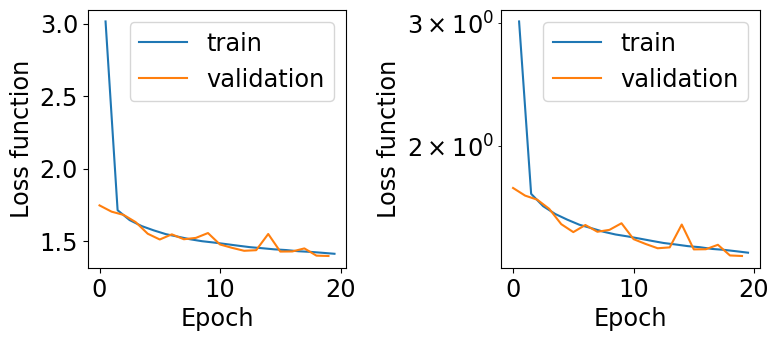

In [16]:
%%time
importlib.reload(emnist_fcn);

#model definition and training
#BEGIN_SOLUTION
inputShape = (28,28)
nNeurons = np.full((16),128)
nOutputNeurons = nCategories

model = emnist_fcn.getModel(inputShape=inputShape, nOutputNeurons=nOutputNeurons,
                            nNeurons=nNeurons,
                            hiddenActivation="relu",
                            outputActivation="softmax")

#configure learning process
initial_learning_rate = 1E-3
batchSize = 64
nEpochs = 20

nStepsPerEpoch = len(x_train)/batchSize
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#run training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(x=x_train, y=y_train,
                    epochs=nEpochs,
                    batch_size = batchSize,
                    validation_split=0.1,
                    callbacks=callbacks,
                    verbose=0)
plf.plotTrainHistory(history)
print(colored("Evaluation on training dataset:","blue"))
model.evaluate(x_train, y_train)
print(colored("Evaluation on test dataset:","blue"))
model.evaluate(x_test, y_test);
#END_SOLUTION
pass

I0000 00:00:1713869645.292327    3134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 48 bytes spill stores, 64 bytes spill loads



4136/4172 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step

I0000 00:00:1713869650.761582    3195 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45', 48 bytes spill stores, 48 bytes spill loads



4172/4172 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


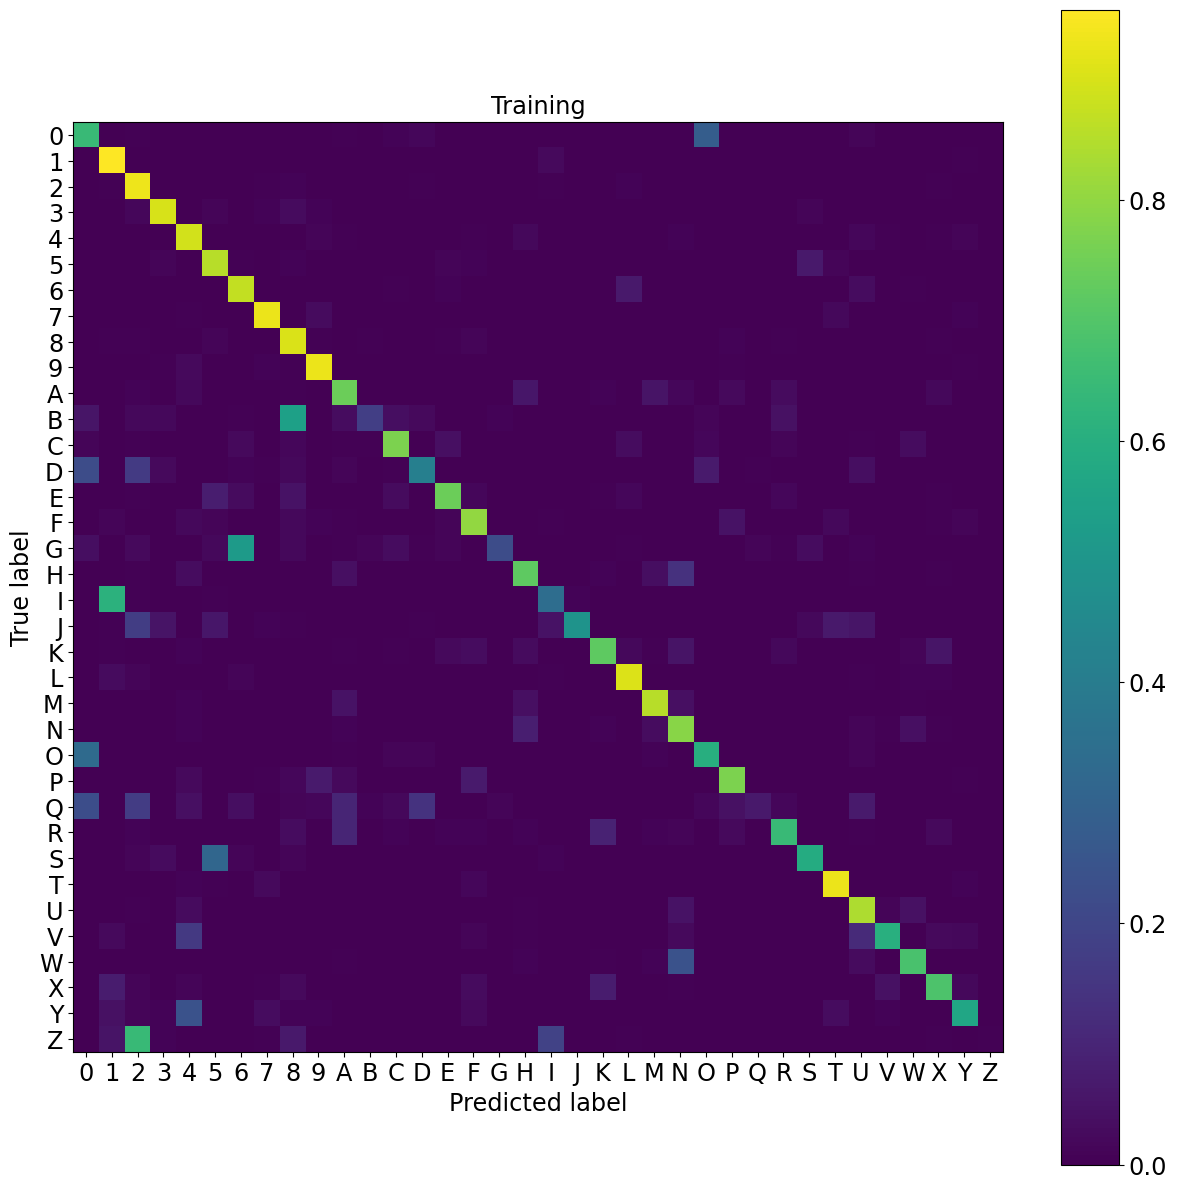

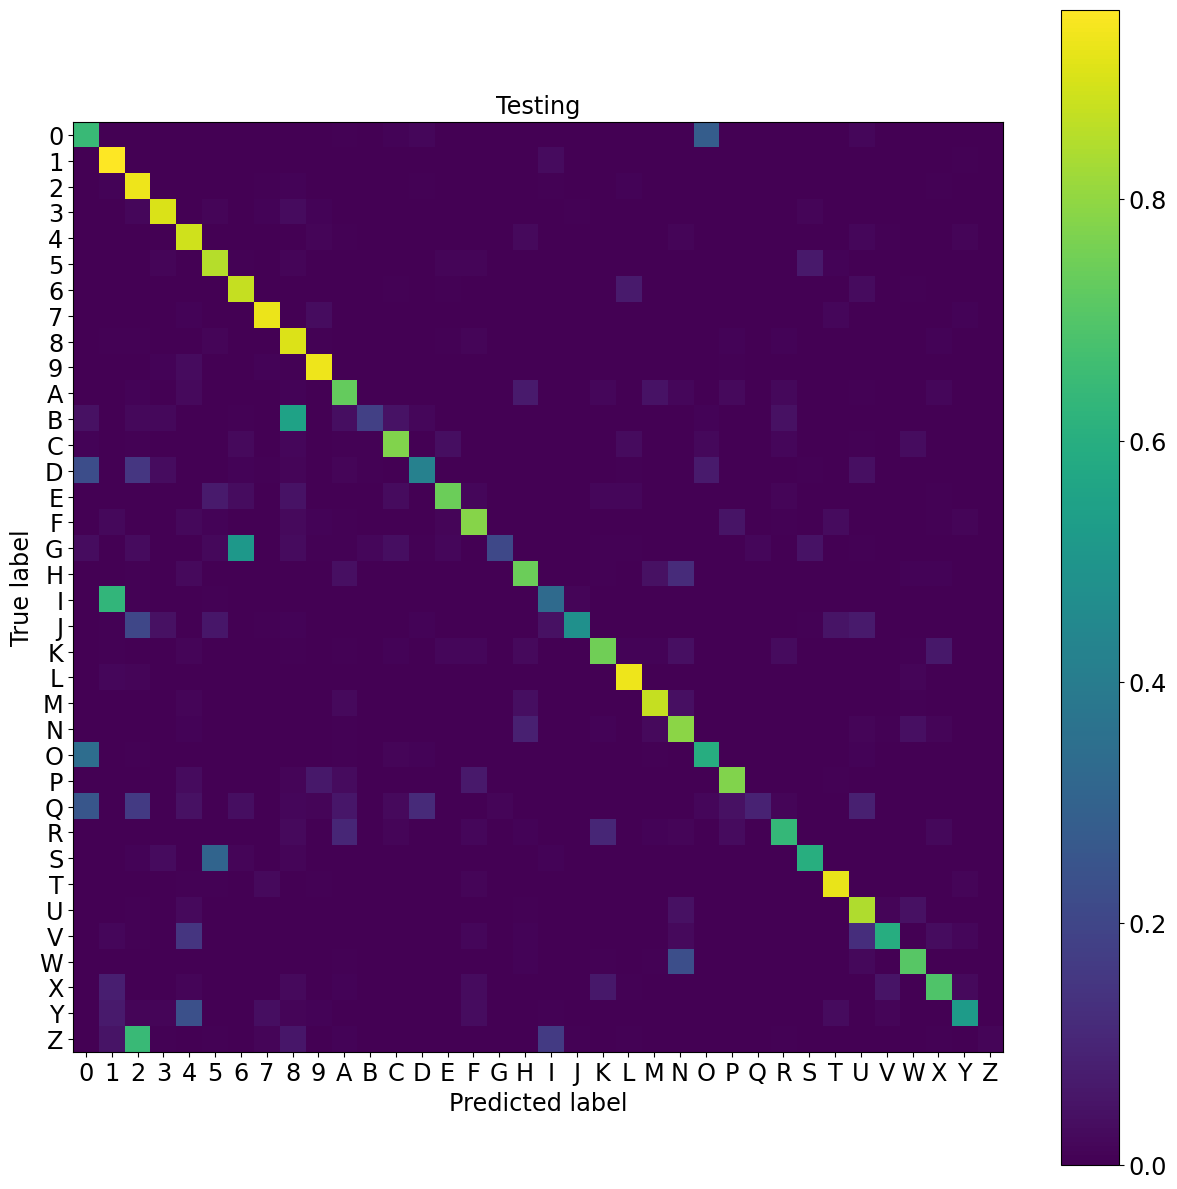

In [17]:
#evaluation
#BEGIN_SOLUTION
importlib.reload(emnist_fcn);
y_pred = tf.argmax(model.predict(x_train, batch_size=128), axis=1)
emnist_fcn.plotMNIST_CM(y_train,y_pred,"Training")

y_pred = tf.argmax(model.predict(x_test,batch_size=128), axis=1)
emnist_fcn.plotMNIST_CM(y_test,y_pred,"Testing")
#END_SOLUTION
pass

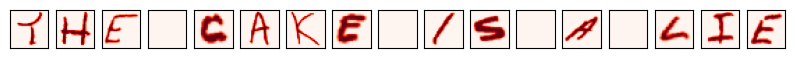

In [18]:
#BEGIN_SOLUTION
#message encoding
importlib.reload(emnist_fcn);
text = "THE CAKE IS A LIE"
encoded = emnist_fcn.encodeMessage(text,x,y);

fileName = "encoded.npz"
with open(fileName, 'wb') as file:
    np.save(file, encoded)
#END_SOLUTION
pass

In [19]:
#message decoding
#BEGIN_SOLUTION
fileName = "../data/encoded.npz"
with open(fileName, 'rb') as file:
    encoded = np.load(file)

spaces_mask = np.sum(encoded, axis=(1,2))>0
decoded = tf.argmax(model.predict(encoded), axis=1)
digits = [str(item) for item in range(0,10)]
letters_upper = list(string.ascii_uppercase)
digits_letters = np.array(digits + letters_upper)
decoded = digits_letters[decoded]
decoded = np.where(spaces_mask, decoded, " ")
decoded = ''.join(decoded)
print(colored("Decoded message is:","blue"),decoded)
#END_SOLUTION
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Decoded message is: TLE 6AKE I3 A L1E
